In [1]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from cohort_loader_new_version0229 import *
import eicu_year_process

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)

import get_hospital_eicu

import split
from imp import reload
reload(split)

import Multiclass_evaluation
reload(Multiclass_evaluation)

c:\Users\DAHS\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Multiclass_evaluation' from 'c:\\Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation\\Multiclass_evaluation.py'>

In [2]:
mimic_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/mimic_analysis(new_version0313).csv.gz'
eicu_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Case Labeling/eicu_analysis(new_version0313).csv.gz'

mimic = pd.read_csv(mimic_path, compression = 'gzip')
mimic = mimic.drop('Shock_next_12h', axis = 1)

eicu = pd.read_csv(eicu_path, compression = 'gzip')
eicu = eicu.drop('Shock_next_12h', axis = 1)

dataset_mimic = mimic[~(mimic['gender']==2)].reset_index(drop=True)

dataset_mimic.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_mimic.fillna(0, inplace=True) 
dataset_mimic = dataset_mimic[~(dataset_mimic['Case']=='event')]
dataset_mimic = dataset_mimic[~((dataset_mimic['INDEX']=='CASE3_CASE4_DF')&(dataset_mimic['Annotation']=='no_circ'))]

eventset = mimic[(mimic['Case']=='event')].reset_index(drop=True)
dataset_mimic['Case'] = pd.to_numeric(dataset_mimic['Case'], errors='coerce')

mimic_train, mimic_valid = data_split(dataset_mimic, 9040, 0.9, Threshold=0.05, n_trial=1, mode = 'mimic')

eicu_t = eicu_year_process.matching_patient(eicu)
dataset_eicu = eicu_t[~(eicu_t['gender']==2)].reset_index(drop=True)
dataset_eicu.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_eicu.fillna(0, inplace=True) 

eicu_test = dataset_eicu[~(dataset_eicu['Case']=='event')]
event_eicu = dataset_eicu[(dataset_eicu['Case']=='event')]
eicu_test = eicu_test[~((eicu_test['INDEX']=='CASE3_CASE4_DF')&(eicu_test['Annotation']=='no_circ'))]
eicu_test['Case'] = pd.to_numeric(eicu_test['Case'], errors='coerce')
hosp_id, eicu_test = get_hospital_eicu.hospital(eicu_test)

eicu_type = get_hospital_eicu.eicu_subgroup(eicu_test)
unitadmitsource, unittype, unitstaytype = get_hospital_eicu.make_eicu_dataset(eicu_type)

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.90, 테스트 = 0.10
학습셋 클래스 비율: Case
1.0    174346
2.0     27608
3.0     70171
4.0     71699
Name: count, dtype: int64
테스트셋 클래스 비율: Case
1.0    17664
2.0     3030
3.0     9456
4.0     8278
Name: count, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.51:0.08:0.20:0.21
테스트셋 클래스 비율: 0.46:0.08:0.25:0.22
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 5323
테스트셋 환자 수: 601
학습셋 체류 수: 5433
테스트셋 체류 수: 604
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.9
임계값: 0.1
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.29
시도한 시행 횟수: 0


In [3]:
reload(split)
X_train, y_train, _ = split.split_X_Y(mimic_train, mode = 'mimic')
X_valid, y_valid, valid_output = split.split_X_Y(mimic_valid, mode = 'mimic')

In [5]:
reload(Multiclass_evaluation) #default setting
models, result = Multiclass_evaluation.create_analysis(eventset, X_train, y_train, X_valid, valid_output, mode = 'base')

ZeroDivisionError
|MIMIC-Validation|====================================================


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,xgb,0.916155,0.9589,0.9633,0.8253,0.7595,0.9351,0.9261,0.9473,0.9128
1,lgbm,0.916103,0.9587,0.9635,0.8291,0.7607,0.9368,0.9258,0.9454,0.9128
2,adaboost,0.675081,0.9270,0.9268,0.5000,0.5668,0.5000,0.6230,0.8432,0.7334
3,catboost,0.916753,0.9600,0.9634,0.8175,0.7639,0.9367,0.9254,0.9448,0.9123
4,rf,0.913943,0.9603,0.9629,0.8148,0.7680,0.9339,0.9198,0.9388,0.9062
5,dt,0.855808,0.9219,0.9392,0.7806,0.6164,0.9134,0.8793,0.8934,0.8586
6,svm-ovr,0.866400,0.9592,0.9614,0.8011,0.7592,0.8666,0.8356,0.8769,0.8146
7,lr,0.864474,0.9579,0.9597,0.7921,0.7460,0.8685,0.8350,0.8733,0.8126
8,naivebayes,0.456178,0.4965,0.7269,0.5000,0.5668,0.5000,0.6230,0.4977,0.1145
9,knn,0.587618,0.7550,0.7961,0.7027,0.5929,0.6503,0.5433,0.6078,0.4509


----------------------------------------------------------------------


In [ ]:
reload(Multiclass_evaluation) #default setting + SMOTE
models, result = Multiclass_evaluation.create_analysis(eventset, X_train, y_train, X_valid, valid_output, mode = 'base')

In [14]:
result.drop('Accuracy', axis = 1).to_excel(excel_writer='internal_validation_baseline_method.xlsx')

In [18]:
lgbm_wrapper = LGBMClassifier(n_estimators = 10, random_state = 42, extra_trees = True, verbose=-1)
            
lgbm_wrapper.fit(X_train, y_train)

valid_preds = lgbm_wrapper.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob_1'] = lgbm_wrapper.predict_proba(X_valid)[:,0]
valid_output['prediction_prob_2'] = lgbm_wrapper.predict_proba(X_valid)[:,1]
valid_output['prediction_prob_3'] = lgbm_wrapper.predict_proba(X_valid)[:,2]
valid_output['prediction_prob_4'] = lgbm_wrapper.predict_proba(X_valid)[:,3]

In [22]:
#case3, case 4 분석
# sample = mimic_valid[mimic_valid['INDEX']=='CASE3_CASE4_DF']
sample = mimic_valid.copy()
sample[sample['stay_id']==39780630][['stay_id','Time_since_ICU_admission','MAP', 'Lactate', 'lactate_up', 'vasoactive/inotropic', 'Annotation', 'progress','Case']]

,stay_id,Time_since_ICU_admission,MAP,Lactate,lactate_up,vasoactive/inotropic,Annotation,progress,Case
8744,39780630,0,91.666667,4.2,0,0,ambiguous,0,2.0
8745,39780630,1,91.666667,4.2,0,0,ambiguous,0,2.0
8746,39780630,2,91.666667,2.2,0,0,ambiguous,0,2.0
8747,39780630,3,91.666667,2.2,0,0,ambiguous,0,2.0
8748,39780630,4,77.555556,2.2,0,1,ambiguous,0,2.0
8749,39780630,5,83.666667,2.2,0,1,circ,1,4.0
8750,39780630,6,85.666667,2.2,0,1,circ,1,4.0
8751,39780630,7,93.666667,2.2,0,0,ambiguous,1,4.0
8752,39780630,8,92.666667,2.2,0,0,ambiguous,1,4.0
8753,39780630,9,79.000000,2.4,1,0,ambiguous,1,4.0


In [19]:
valid_output[valid_output['stay_id']==sample.stay_id.unique()[3]]

,stay_id,Time_since_ICU_admission,Annotation,after_shock_annotation,progress,Case,INDEX,prediction_label,prediction_prob,prediction_prob_1,prediction_prob_2,prediction_prob_3,prediction_prob_4
8744,39780630,0,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,2.0,0.984934,0.214055,0.637989,0.073279,0.074677
8745,39780630,1,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,2.0,0.958439,0.214055,0.637989,0.073279,0.074677
8746,39780630,2,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,2.0,0.819488,0.210073,0.644723,0.071916,0.073288
8747,39780630,3,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,2.0,0.819088,0.210073,0.644723,0.071916,0.073288
8748,39780630,4,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,2.0,0.915399,0.155983,0.700539,0.071061,0.072417
8749,39780630,5,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.000559,0.147604,0.031822,0.209960,0.610614
8750,39780630,6,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.000159,0.145604,0.031391,0.207115,0.615889
8751,39780630,7,ambiguous,not_recov,1,4,CASE3_CASE4_DF,4.0,0.000588,0.143137,0.030859,0.210399,0.615604
8752,39780630,8,ambiguous,not_recov,1,4,CASE3_CASE4_DF,4.0,0.001023,0.142910,0.030810,0.197444,0.628836
8753,39780630,9,ambiguous,not_recov,1,4,CASE3_CASE4_DF,4.0,0.001978,0.146299,0.031541,0.177451,0.644709


In [4]:
#optuna
import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Experiment(Supervised Learning)/evaluation/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
import classifier_ML
reload(classifier_ML)

sampler = TPESampler(seed=10)

def objective(trial):

    param = {
        'objective': 'multiclass',
        'verbose': -1,
        'metric': 'multi_logloss', 
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        "num_class": 4,
        'max_depth': trial.suggest_int('max_depth',10, 300),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 9, 11),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),

    }

    model = LGBMClassifier(**param, early_stopping_rounds=25, random_state =42)
    lgb_model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    valid_preds = lgb_model.predict(X_valid)
    valid_output['prediction_label'] = valid_preds
    valid_output['prediction_prob'] = lgb_model.predict_proba(X_valid)[:, 1]
    
    result = Multiclass_evaluation.MULT_evaluation(valid_output, eventset, 'lgbm', 'mimic')
    
    return result['Case 2 AUPRC'].values[0]
        
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective, n_trials=30)
print('LightGBM Best parameters:', study_lgb.best_params)

[I 2024-03-13 23:28:38,660] A new study created in memory with name: no-name-09f9ea9d-2e40-4a75-bcd4-05f9ea8dda34
[I 2024-03-13 23:28:41,614] Trial 0 finished with value: 0.7619 and parameters: {'extra_trees': True, 'class_weight': None, 'max_depth': 155, 'lambda_l1': 1.0547992438188775e-06, 'lambda_l2': 6.061300044367956e-07, 'n_estimators': 11, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 0 with value: 0.7619.
[I 2024-03-13 23:28:44,484] Trial 1 finished with value: 0.7591 and parameters: {'extra_trees': False, 'class_weight': None, 'max_depth': 246, 'lambda_l1': 0.003256376421394008, 'lambda_l2': 0.03131827670437561, 'n_estimators': 9, 'min_child_samples': 93, 'subsample': 0.7698715745641292}. Best is trial 0 with value: 0.7619.
[I 2024-03-13 23:28:47,303] Trial 2 finished with value: 0.7529 and parameters: {'extra_trees': True, 'class_weight': None, 'max_depth': 138, 'lambda_l1': 8.056120247993029e-05, 'lambda_l2': 0.0036299680810414838, 'n_estimators': 

LightGBM Best parameters: {'extra_trees': False, 'class_weight': None, 'max_depth': 16, 'lambda_l1': 0.00931643639022381, 'lambda_l2': 5.281604602569073e-05, 'n_estimators': 11, 'min_child_samples': 5, 'subsample': 0.43471511774827337}


In [42]:
X_train.shape

(343824, 226)

In [5]:
reload(Multiclass_evaluation)

lgbm_tune = LGBMClassifier(max_depth = 16, lambda_l1 =  0.00931643639022381, lambda_l2 = 5.281604602569073e-05, 
                       
                           n_estimators = 11, min_child_samples = 5, subsample =  0.43471511774827337,
                           random_state = 42, extra_trees = False, verbose=-1)


lgbm_tune.fit(X_train, y_train)

valid_preds = lgbm_tune.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_tune.predict_proba(X_valid)[:, 1]
    
validation_tune = Multiclass_evaluation.MULT_evaluation(valid_output, eventset, 'lgbm', 'mimic')
print('Tuned evaluation')
display(validation_tune)

result_external = Multiclass_evaluation.external_evaluation(unitadmitsource, unittype, unitstaytype, lgbm_tune, 'LightGBM', event_eicu)
# result_external.to_excel(excel_writer='external_validation_baseline_method.xlsx')

Tuned evaluation


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,lgbm,0.916363,0.9598,0.962,0.7942,0.7659,0.9374,0.9256,0.9444,0.9126


[Starting eICU-Test]
eICU-UnitAdmitSource...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError
eICU-UnitType...
eICU-UnitStayType...
ZeroDivisionError
ZeroDivisionError
ZeroDivisionError


Model  Accuracy  Case 1 AUROC  \
Subpopulation   eICU Type                                                
UnitAdmitSource Floor                 LightGBM  0.893373        0.9046   
                Emergency Department  LightGBM  0.885180        0.9031   
                Recovery Room         LightGBM  0.883535        0.9073   
                Direct Admit          LightGBM  0.863611        0.8825   
                Operating Room        LightGBM  0.875801        0.9017   
                Step-Down Unit (SDU)  LightGBM  0.900477        0.8979   
                Other ICU             LightGBM  0.907895        0.8790   
                Other Hospital        LightGBM  0.900443        0.9157   
                Acute Care/Floor      LightGBM  0.897952        0.8859   
                ICU                   LightGBM  0.929023        0.8560   
                PACU                  LightGBM  0.911013        0.9385   
                Observation           LightGBM  0.607143        0.8095   
                ICU to SDU            LightGBM  0.863636        0.8929   
UnitType        Med-Surg ICU          LightGBM  0.883327        0.9029   
                MICU                  LightGBM  0.882491        0.8932   
                Neuro ICU             LightGBM  0.890210        0.8937   
                Cardiac ICU           LightGBM  0.897510        0.8867   
                SICU                  LightGBM  0.890937        0.9194   
                CTICU                 LightGBM  0.895210        0.8826   
                CCU-CTICU             LightGBM  0.889777        0.9011   
                CSICU                 LightGBM  0.897235        0.8961   
UnitStayType    admit                 LightGBM  0.884178        0.9003   
                transfer              LightGBM  0.904505        0.9115   
                readmit               LightGBM  0.899955        0.8939   
                stepdown/other        LightGBM  0.863636        0.8929   

                                      Case 1 AUPRC  Case 2 AUROC  \
Subpopulation   eICU Type                                          
UnitAdmitSource Floor                       0.9308        0.5363   
                Emergency Department        0.9239        0.5303   
                Recovery Room               0.9231        0.5425   
                Direct Admit                0.9134        0.5386   
                Operating Room              0.9220        0.5374   
                Step-Down Unit (SDU)        0.9402        0.5078   
                Other ICU                   0.9542        0.5585   
                Other Hospital              0.9400        0.5597   
                Acute Care/Floor            0.9358        0.5088   
                ICU                         0.9647        0.5032   
                PACU                        0.9208        0.5237   
                Observation                 0.7333        1.0000   
                ICU to SDU                  0.9610        0.6250   
UnitType        Med-Surg ICU                0.9221        0.5214   
                MICU                        0.9249        0.5430   
                Neuro ICU                   0.9397        0.5469   
                Cardiac ICU                 0.9372        0.5222   
                SICU                        0.9264        0.5722   
                CTICU                       0.9513        0.5339   
                CCU-CTICU                   0.9307        0.5670   
                CSICU                       0.9358        0.5050   
UnitStayType    admit                       0.9260        0.5325   
                transfer                    0.9399        0.5471   
                readmit                     0.9403        0.5218   
                stepdown/other              0.9610        0.6250   

                                      Case 2 AUPRC Case 3 AUROC Case 3 AUPRC  \
Subpopulation   eICU Type                                                      
UnitAdmitSource Floor                       0

In [41]:
result_external.to_excel(excel_writer='external_validation_baseline_method.xlsx')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

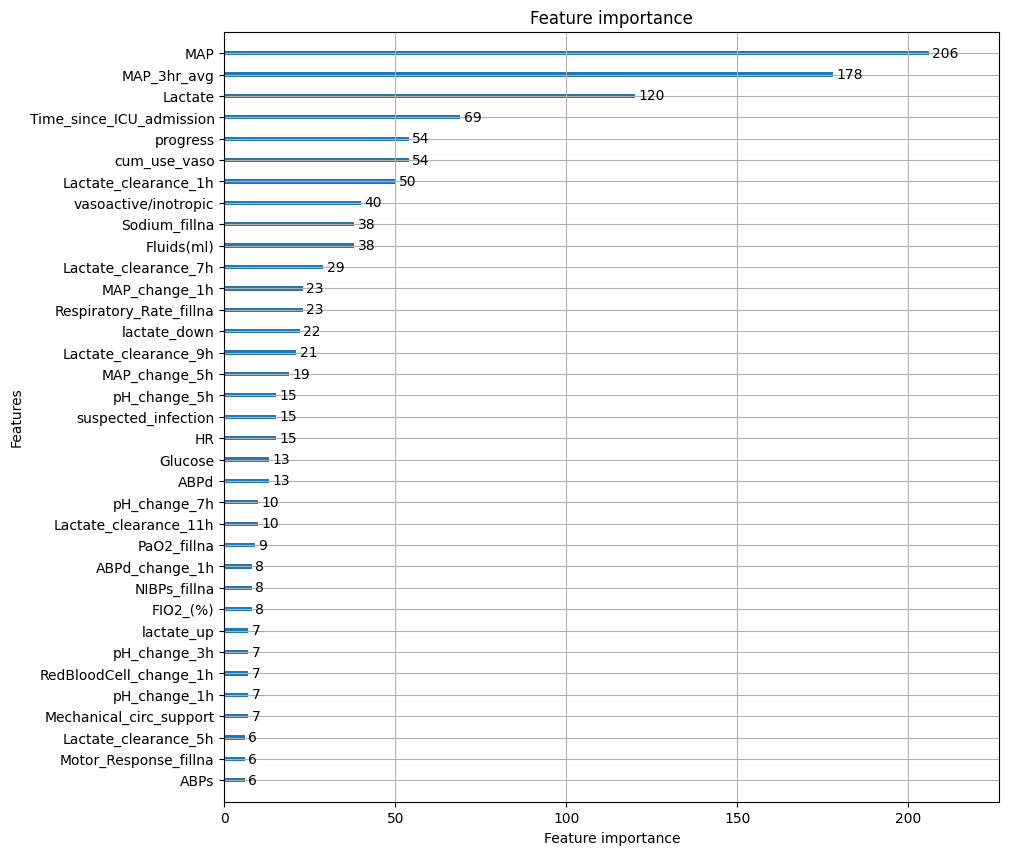

In [39]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,10))
plot_importance(lgbm_tune, max_num_features=35, ax = ax)

In [35]:
# 만약 proposed method를 통해 type 별 분석시 인사이트가 없다면 그냥
# 그냥 eicu 전체에 대해서 평가
reload(split)
X_test, y_test, test_output = split.split_X_Y(eicu_test, mode = 'eicu')

test_preds = lgbm_tune.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = lgbm_tune.predict_proba(X_test)[:, 1]

test_eval = Multiclass_evaluation.MULT_evaluation(test_output, event_eicu, 'lgbm', 'eicu')
print('Test evaluation')
display(test_eval)

Test evaluation


,Model,Accuracy,Case 1 AUROC,Case 1 AUPRC,Case 2 AUROC,Case 2 AUPRC,Case 3 AUROC,Case 3 AUPRC,Case 4 AUROC,Case 4 AUPRC
0,lgbm,0.887374,0.9012,0.9285,0.5335,0.3357,0.8851,0.8459,0.9798,0.9694


In [36]:
cosine, alpha = Multiclass_evaluation.ACID(test_output, event_eicu, 'eicu')

In [42]:
test_output

,patientunitstayid,Time_since_ICU_admission,Annotation,after_shock_annotation,progress,Case,INDEX,prediction_label,prediction_prob
0,2760705,0,no_circ,before_experience_shock,0,2,CASE1_CASE2_DF,1.0,0.110949
1,2760705,1,no_circ,before_experience_shock,0,2,CASE1_CASE2_DF,1.0,0.087111
2,2760705,2,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,1.0,0.259836
3,2760705,3,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,1.0,0.259836
4,2760705,4,ambiguous,before_experience_shock,0,2,CASE1_CASE2_DF,1.0,0.259836
...,...,...,...,...,...,...,...,...,...
210541,1097725,799,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.024824
210542,1097725,800,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.024824
210543,1097725,801,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.024824
210544,1097725,802,circ,not_recov,1,4,CASE3_CASE4_DF,4.0,0.024824


In [41]:
cosine

0.13007574041043446

In [53]:
result.to_excel(excel_writer='external_validation_baseline_method.xlsx')

In [14]:
#tracking system
reload(split)


X_viz, y_train_viz, output_viz = split.split_X_Y_for_VIZ(mimic_train, mode = 'mimic')
X_valid_viz, y_train_valid_viz, output_valid_viz = split.split_X_Y_for_VIZ(mimic_valid, mode = 'mimic')
X_test_viz, y_test_viz, test_output_viz = split.split_X_Y_for_VIZ(eicu_test, mode = 'eicu')

lgbm_tune = LGBMClassifier(max_depth = 16, lambda_l1 =  0.00931643639022381, lambda_l2 = 5.281604602569073e-05, 
                       
                           n_estimators = 11, min_child_samples = 5, subsample =  0.43471511774827337,
                           random_state = 42, extra_trees = False, verbose=-1)


lgbm_tune.fit(X_viz, y_train_viz)

preds = lgbm_tune.predict(X_viz)
output_viz['prediction_label'] = preds
output_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_viz)[:, 1]
output_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_viz)[:, 2]
output_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_viz)[:, 3]

preds = lgbm_tune.predict(X_valid_viz)
output_valid_viz['prediction_label'] = preds
output_valid_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_valid_viz)[:, 1]
output_valid_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_valid_viz)[:, 2]
output_valid_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_valid_viz)[:, 3]

test_preds = lgbm_tune.predict(X_test_viz)
test_output_viz['prediction_label'] = test_preds
test_output_viz['prediction_prob_case2'] = lgbm_tune.predict_proba(X_test_viz)[:, 1]
test_output_viz['prediction_prob_case3'] = lgbm_tune.predict_proba(X_test_viz)[:, 2]
test_output_viz['prediction_prob_case4'] = lgbm_tune.predict_proba(X_test_viz)[:, 3]

In [15]:
event_cohort_viz = output_viz[output_viz.stay_id.isin(eventset.stay_id.unique())]
event_cohort_eval = output_valid_viz[output_valid_viz.stay_id.isin(eventset.stay_id.unique())]
event_cohort_test = test_output_viz[test_output_viz.patientunitstayid.isin(event_eicu.patientunitstayid.unique())]

In [16]:
mimic_origin = pd.read_csv(mimic_path, compression = 'gzip')
eicu_origin = pd.read_csv(eicu_path, compression='gzip')

recovery = mimic_origin[(mimic_origin['INDEX']=='CASE3_CASE4_DF')&(mimic_origin['Annotation']=='no_circ')]
recovery_eval = event_cohort_eval[event_cohort_eval['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])
no_recovery_eval = event_cohort_eval[~event_cohort_eval['stay_id'].isin(recovery.stay_id.unique())].sort_values(by=['stay_id', 'Time_since_ICU_admission'])

recovery_e = eicu_origin[(eicu_origin['INDEX']=='CASE3_CASE4_DF')&(eicu_origin['Annotation']=='no_circ')]
recovery_test = event_cohort_test[event_cohort_test['patientunitstayid'].isin(recovery_e.patientunitstayid.unique())].sort_values(by=['patientunitstayid', 'Time_since_ICU_admission'])
no_recovery_test = event_cohort_test[~event_cohort_test['patientunitstayid'].isin(recovery_e.patientunitstayid.unique())].sort_values(by=['patientunitstayid', 'Time_since_ICU_admission'])

In [30]:
def NSA(recover, no_recover, mode):
    
    recover_df = recover.copy()
    no_recover_df = no_recover.copy()
    
    
    if mode == 'mimic':
        stay_id_id = 'stay_id'
    else:
        stay_id_id ='patientunitstayid'
        
    recover_set = []

    for idx, stay in enumerate(recover_df[stay_id_id].unique()):
        interest = recover_df[recover_df[stay_id_id]==stay]
        before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
        before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
        before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

        if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
            before_shock_score = 1
        else:
            before_shock_score = 0

        #---------------------------------------------------------------------------------------------
        interest = recover_df[recover_df[stay_id_id]==stay]
        after_shock = interest.iloc[[-1]]
        after_shock['Case'] = after_shock['Case'].replace({3:1, 4:0})
        after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:1, 4:0})

        after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
        #---------------------------------------------------------------------------------------------

        nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
        recover_set.append(nsa)
        
    no_recover_set = []

    for stay in no_recover_df[stay_id_id].unique():
        
        interest = no_recover_df[no_recover_df[stay_id_id]==stay]
        before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
        before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
        before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

        if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
            before_shock_score = 1
        else:
            before_shock_score = 0

        #---------------------------------------------------------------------------------------------
        interest = no_recover_df[no_recover_df[stay_id_id]==stay]
        after_shock = interest.iloc[[-1]]
        after_shock['Case'] = after_shock['Case'].replace({3:0, 4:1})
        after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:0, 4:1})

        after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
        #---------------------------------------------------------------------------------------------

        nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
        no_recover_set.append(nsa)
    nsa = (np.array(recover_set).mean() + np.array(no_recover_set).mean())/2
    return nsa

val_nsa = NSA(recovery_eval, no_recovery_eval, 'mimic')
test_nsa = NSA(recovery_test, no_recovery_test, 'eicu')

In [31]:
val_nsa

0.7055859137826351

In [32]:
test_nsa

0.157189616498742

In [33]:
def NSA_Curve(recover, no_recover, mode):
    
    recover_df = recover.copy()
    no_recover_df = no_recover.copy()
    
    thresholds = np.linspace(0, 1, 21)
    threshold_by_score = []
    
    if mode == 'mimic':
        stay_id_id = 'stay_id'
    else:
        stay_id_id ='patientunitstayid'
    
    for th in thresholds:    
        recover_set = []

        for idx, stay in enumerate(recover_df[stay_id_id].unique()):
            interest = recover_df[recover_df[stay_id_id]==stay]
            before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
            before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
            before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})
            
            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case2'] >= th, before_shock['Case'], 0)

            if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
                before_shock_score = 1
            else:
                before_shock_score = 0

            #---------------------------------------------------------------------------------------------
            interest = recover_df[recover_df[stay_id_id]==stay]
            after_shock = interest.iloc[[-1]]
            after_shock['Case'] = after_shock['Case'].replace({3:1, 4:0})
            after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:1, 4:0})

            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case3'] >= th, before_shock['Case'], 0)
            
            after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
            #---------------------------------------------------------------------------------------------

            nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
            recover_set.append(nsa)
            
        no_recover_set = []

        for stay in no_recover_df[stay_id_id].unique():
            
            interest = no_recover_df[no_recover_df[stay_id_id]==stay]
            before_shock = interest[interest['after_shock_annotation']=='before_experience_shock']
            before_shock['Case'] = before_shock['Case'].replace({1:0, 2:1})
            before_shock['prediction_label'] = before_shock['prediction_label'].replace({1:0, 2:1})

            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case2'] >= th, before_shock['Case'], 0)
            
            if before_shock[before_shock['Case']==1]['prediction_label'].sum() >= 1:
                before_shock_score = 1
            else:
                before_shock_score = 0

            #---------------------------------------------------------------------------------------------
            interest = no_recover_df[no_recover_df[stay_id_id]==stay]
            after_shock = interest.iloc[[-1]]
            after_shock['Case'] = after_shock['Case'].replace({3:0, 4:1})
            after_shock['prediction_label'] = after_shock['prediction_label'].replace({3:0, 4:1})
            before_shock['prediction_label'] = np.where(before_shock['prediction_prob_case4'] >= th, before_shock['Case'], 0)
            after_shock_score = recall_score(after_shock['Case'], after_shock['prediction_label'])
            #---------------------------------------------------------------------------------------------

            # nsa = np.round((before_shock_score + after_shock_score + 0.00000001)/(2+0.00000001), 4)
            nsa = (0.7*np.array(before_shock_score).mean() + 0.3*np.array(after_shock_score).mean())
            no_recover_set.append(nsa)
        nsa = (np.array(recover_set).mean() + np.array(no_recover_set).mean())/2
        threshold_by_score.append(nsa)
    return threshold_by_score

threshold_by_score_val = NSA_Curve(recovery_eval, no_recovery_eval, 'mimic')
threshold_by_score_test = NSA_Curve(recovery_test, no_recovery_test, 'eicu')

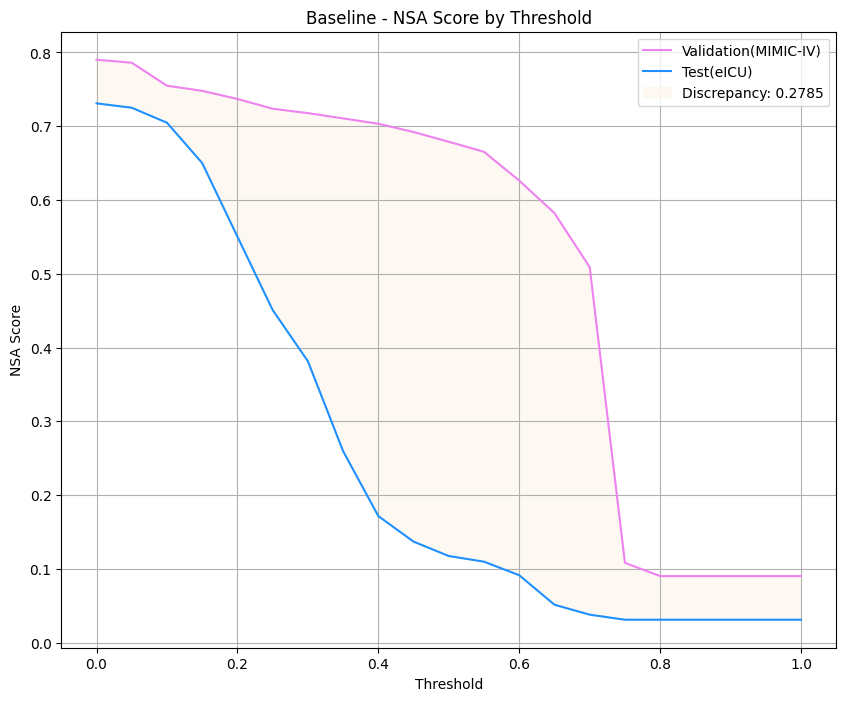

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
thresholds = np.linspace(0, 1, 21)

plt.figure(figsize=(10, 8))
plt.plot(thresholds, threshold_by_score_val, label = 'Validation(MIMIC-IV)', color='violet')
plt.plot(thresholds, threshold_by_score_test, label = 'Test(eICU)', color='dodgerblue')

area = np.trapz(np.abs(np.array(threshold_by_score_val) - np.array(threshold_by_score_test)), thresholds)
plt.fill_between(thresholds, threshold_by_score_val, threshold_by_score_test, color='oldlace', alpha=0.5, label = 'Discrepancy: {}'.format(np.round(area,4)))

plt.title('Baseline - NSA Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('NSA Score')
plt.grid(True)
plt.legend()
plt.show()